<a href="https://colab.research.google.com/github/EddyGiusepe/Overfitting_and_Regularization/blob/main/Regularization_for_Overfitting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h2 align="center">Overfitting e Regularização</h2>


Data Scientist: Dr.Eddy Giusepe Chirinos Isidro

# Regularization

Como temos percebido, quando treinamos Redes Neurais corremos o risco de fazer `OVERFITTING` aos Dados de Treinamento, o qual será traduzido em uma má performance de nosso modelo quando receba Dados que nunca haja visto (ou seja não haverá GENERALIZADO). A melhor maneira de saber se nosso modelo tem Overfitting é observando as Curvas de Treinamento (<font color="orange">ver o gráfico a seguir</font>).

Neste script vamos treinar uma `MLP` no Dataset [CIFAR10](https://www.cs.toronto.edu/~kriz/cifar.html) para classificação de imagens em $10$ classes diferentes.

![](https://hidden.brutalk.com/wp-content/uploads/2021/02/1614208808_358_How-to-use-Learning-Curves-to-Diagnose-Machine-Learning-Model.png)

Usaremos a biblioteca `torchvision` para descarregar o Dataset. 

Este Dataset está formado por imagens em cor de baixa resolução, temos $50000$ imagens de Treinamento e $10000$ de teste. O objetivo é classificar em $10$ classes diferentes. Vejamos alguns exemplos:

In [ ]:
import torchvision

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

len(trainset), len(testset)

Files already downloaded and verified
Files already downloaded and verified


(50000, 10000)

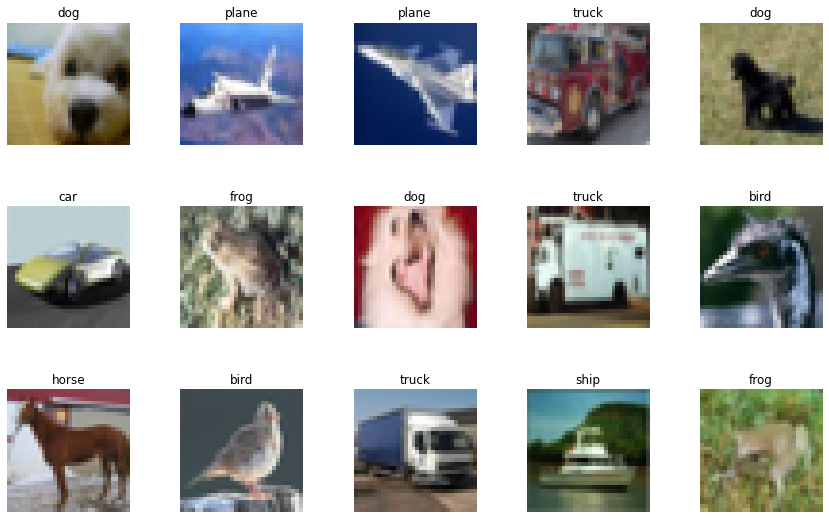

In [ ]:
import random 
import matplotlib.pyplot as plt
%matplotlib inline

r, c = 3, 5
plt.figure(figsize=(c*3, r*3))
for row in range(r):
    for col in range(c):
        index = c*row + col
        plt.subplot(r, c, index + 1)
        ix = random.randint(0, len(trainset)-1)
        img, label = trainset[ix]
        plt.imshow(img)
        plt.axis('off')
        plt.title(classes[label])
plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()

A seguir vamos a transformar as imagens em `arrays` de `NumPy` para poder trabalhar com elas mais facilmente.

In [ ]:
import numpy as np


train_images = np.array([np.array(img) for img, label in trainset])
X_test = np.array([np.array(img) for img, label in testset])

train_labels = np.array([label for img, label in trainset])
y_test = np.array([label for img, label in testset])

X_train, X_val, X_subset = train_images[:40000], train_images[40000:], train_images[:5000]
y_train, y_val, y_subset = train_labels[:40000], train_labels[40000:], train_labels[:5000]


X_train.shape, X_val.shape, X_test.shape, X_subset.shape

((40000, 32, 32, 3), (10000, 32, 32, 3), (10000, 32, 32, 3), (5000, 32, 32, 3))

Agora, podemos aplicar de forma similar o código para treinar um [The Multilayer Perceptron](https://github.com/EddyGiusepe/Perceptron_with_Python/blob/main/The_Multilayer_Perceptron_(MLP)_.ipynb), e assim poder observar as curvas de Treinamento.

In [ ]:
import torch



class Dataset(torch.utils.data.Dataset):
    def __init__(self, X, Y):
        self.X = torch.from_numpy(X / 255.).float().cuda().view(-1, 32*32*3)
        self.Y = torch.from_numpy(Y).long().cuda()
    def __len__(self):
        return len(self.X)
    def __getitem__(self, ix):
        return self.X[ix], self.Y[ix]

dataset = {
    'train': Dataset(X_subset, y_subset),
    'val': Dataset(X_val, y_val),
}

dataloader = {
    'train': torch.utils.data.DataLoader(dataset['train'], batch_size=32, shuffle=True),
    'val': torch.utils.data.DataLoader(dataset['val'], batch_size=1000, shuffle=False)
}

len(dataset['train']), len(dataset['val'])

(5000, 10000)

In [ ]:
from sklearn.metrics import accuracy_score



def softmax(x):
    return torch.exp(x) / torch.exp(x).sum(axis=-1,keepdims=True)

def build_model(D_in=32*32*3, H=100, D_out=10):
    return torch.nn.Sequential(
        torch.nn.Linear(D_in, H),
        torch.nn.ReLU(),
        torch.nn.Linear(H, H),
        torch.nn.ReLU(),
        torch.nn.Linear(H, D_out)
    ).cuda()


def fit(model, dataloader, epochs=100, log_each=10, weight_decay=0):
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=0.1, weight_decay=weight_decay)
    l, acc = [], []
    val_l, val_acc = [], []
    for e in range(1, epochs+1): 
        _l, _acc = [], []
        model.train()
        for x_b, y_b in dataloader['train']:
            y_pred = model(x_b)
            loss = criterion(y_pred, y_b)
            _l.append(loss.item())
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            y_probas = torch.argmax(softmax(y_pred), axis=1)            
            _acc.append(accuracy_score(y_b.cpu().numpy(), y_probas.cpu().detach().numpy()))
        l.append(np.mean(_l))
        acc.append(np.mean(_acc))
        model.eval()
        _l, _acc = [], []
        with torch.no_grad():
            for x_b, y_b in dataloader['val']:
                y_pred = model(x_b)
                loss = criterion(y_pred, y_b)
                _l.append(loss.item())
                y_probas = torch.argmax(softmax(y_pred), axis=1)            
                _acc.append(accuracy_score(y_b.cpu().numpy(), y_probas.cpu().numpy()))
        val_l.append(np.mean(_l))
        val_acc.append(np.mean(_acc))
        if not e % log_each:
            print(f"Epoch {e}/{epochs} loss {l[-1]:.5f} acc {acc[-1]:.5f} val_loss {val_l[-1]:.5f} val_acc {val_acc[-1]:.5f}")
    return {'epoch': list(range(1, epochs+1)), 'loss': l, 'acc': acc, 'val_loss': val_l, 'val_acc': val_acc}

In [ ]:
model = build_model()
hist = fit(model, dataloader)

Epoch 10/100 loss 1.84838 acc 0.33778 val_loss 2.01500 val_acc 0.29180
Epoch 20/100 loss 1.68963 acc 0.39550 val_loss 1.84446 val_acc 0.33620
Epoch 30/100 loss 1.56141 acc 0.43690 val_loss 1.86906 val_acc 0.33920
Epoch 40/100 loss 1.45812 acc 0.48308 val_loss 1.87057 val_acc 0.35050
Epoch 50/100 loss 1.34955 acc 0.52349 val_loss 2.12853 val_acc 0.29990
Epoch 60/100 loss 1.25020 acc 0.56071 val_loss 2.04047 val_acc 0.34780
Epoch 70/100 loss 1.14294 acc 0.60629 val_loss 1.93962 val_acc 0.36620
Epoch 80/100 loss 1.05339 acc 0.62659 val_loss 2.08970 val_acc 0.36560
Epoch 90/100 loss 0.94940 acc 0.66819 val_loss 1.97324 val_acc 0.37790
Epoch 100/100 loss 0.85157 acc 0.70283 val_loss 2.99589 val_acc 0.28920


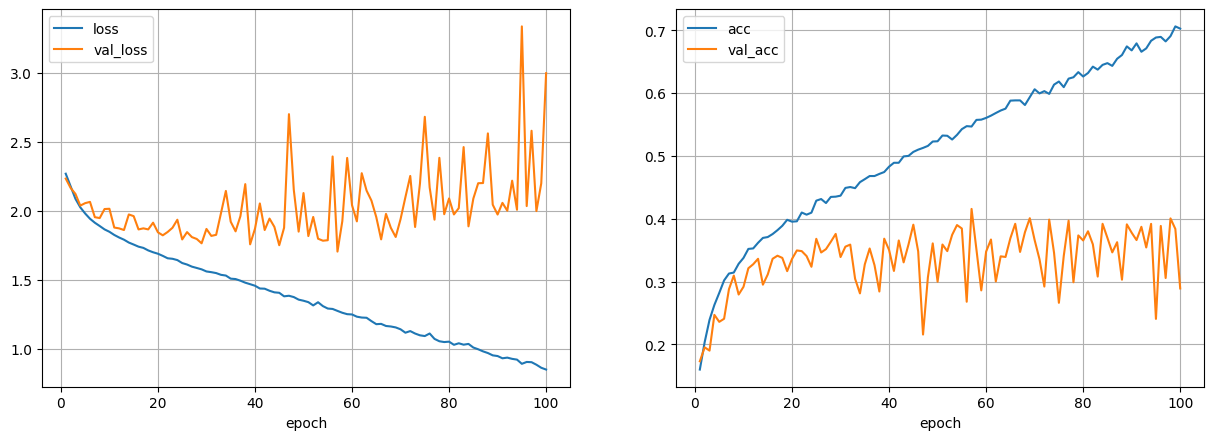

In [ ]:
import pandas as pd

fig = plt.figure(dpi=100, figsize=(15,5))
ax = plt.subplot(121)
pd.DataFrame(hist).plot(x='epoch', y=['loss', 'val_loss'], grid=True, ax=ax)
ax = plt.subplot(122)
pd.DataFrame(hist).plot(x='epoch', y=['acc', 'val_acc'], grid=True, ax=ax)
plt.show()

Como podemos observar nas curvas de Treinamento, as métricas para o conjunto de Dados de `Treinamento` vão melhorando epoch tras epoch, no entanto as métricas de `validação` rapidamente se estancam e começam a piorar. Isto é um sinal claro de que nosso Modelo está sofrendo de `Overfitting`.


Seguidamente estudaremos as diferentes técnicas de `REGULARIZAÇÃO`, o término técnico utilizado para referirmos às diferentes técnicas de redução de Overfitting.

# Regularização $L2$

Esta técnica é muito usada. Esta técnica consiste em penalizar (restringuir) a magnitude dos pesos da `Rede Neural`, forçando-os a ser valores pequenos. Para efeitos práticos, a `REGULARIZAÇÃO L2` se implementa como um término extra na Função de Perda, assim:


$$ l = CE(\hat{y}, y) + \alpha \frac{1}{2} || \mathbf{w} || $$


onde $CE(\hat{y}, y)$ é a função `Cross Entropy` (ou qualquer outra função de perda, dependendo da tarefa que estes realizando), $\mathbf{w}$ são os pesos da rede e $α$ é um parâmetro que indica quanto queremos regularizar o modelo. Em `Pytorch` podemos adicionar o valor de $α$ através do parâmetro `weight_decay` diretamente no otimizador (<font color="orange">por dafault é $0$</font>). Valores típicos usados estão no intervalo de $[0.001, 0.01]$. 

In [ ]:
model = build_model()
hist = fit(model, dataloader, weight_decay=0.05)

Epoch 10/100 loss 2.07567 acc 0.20561 val_loss 2.10797 val_acc 0.19980
Epoch 20/100 loss 2.07724 acc 0.20979 val_loss 2.53535 val_acc 0.13110
Epoch 30/100 loss 2.08081 acc 0.21338 val_loss 2.08717 val_acc 0.20110
Epoch 40/100 loss 2.09267 acc 0.20541 val_loss 2.19454 val_acc 0.16720
Epoch 50/100 loss 2.08664 acc 0.20999 val_loss 2.12886 val_acc 0.20060
Epoch 60/100 loss 2.07763 acc 0.21517 val_loss 2.07530 val_acc 0.20530
Epoch 70/100 loss 2.09744 acc 0.20322 val_loss 2.11473 val_acc 0.19040
Epoch 80/100 loss 2.08301 acc 0.20581 val_loss 2.07710 val_acc 0.21660
Epoch 90/100 loss 2.08056 acc 0.21497 val_loss 2.20806 val_acc 0.17440
Epoch 100/100 loss 2.08869 acc 0.21298 val_loss 2.09196 val_acc 0.21650


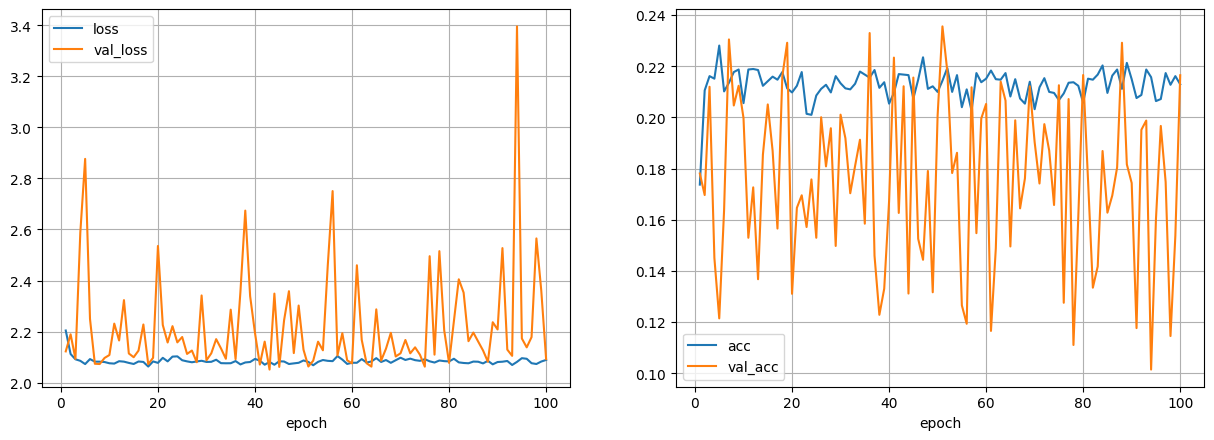

In [ ]:
#fig = plt.figure(dpi=200, figsize=(10,3))
fig = plt.figure(dpi=100, figsize=(15,5))
ax = plt.subplot(121)
pd.DataFrame(hist).plot(x='epoch', y=['loss', 'val_loss'], grid=True, ax=ax)
ax = plt.subplot(122)
pd.DataFrame(hist).plot(x='epoch', y=['acc', 'val_acc'], grid=True, ax=ax)
plt.show()

como podemo observar, agora, as curvas de Treinamento e Validação estão mais próximas (`as curvas Loss`), pelo que precebimos que conseguimos diminuir o Overfitting. <font color="orange">É importante dizer que reduzir o `Overfitting` não implica melhorar as métricas (o grafico de accuracy)</font>. 

# Early Stopping

Esta é outra técnica utilizada para regularizar um modelo. Esta técnica consiste em levar um registro das métricas de Validação durante o Treinamento, salvar os pesos do modelo cada vez que as métricas melhoram e, uma vez que termina o treinamento, carregar os melhores pesos invés de ficar com os últimos. De forma opcional também podemos deter o treinamento se em caso não melhora as nossas métricas durante um determinado número de epochs seguidas, o qual podemos traduzir numa economia de tempo e computo.

In [ ]:
def fit(model, dataloader, epochs=100, log_each=10, weight_decay=0, early_stopping=0):
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=0.1, weight_decay=weight_decay)
    l, acc = [], []
    val_l, val_acc = [], []
    best_acc, step = 0, 0
    for e in range(1, epochs+1): 
        _l, _acc = [], []
        model.train()
        for x_b, y_b in dataloader['train']:
            y_pred = model(x_b)
            loss = criterion(y_pred, y_b)
            _l.append(loss.item())
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            y_probas = torch.argmax(softmax(y_pred), axis=1)            
            _acc.append(accuracy_score(y_b.cpu().numpy(), y_probas.cpu().detach().numpy()))
        l.append(np.mean(_l))
        acc.append(np.mean(_acc))
        model.eval()
        _l, _acc = [], []
        with torch.no_grad():
            for x_b, y_b in dataloader['val']:
                y_pred = model(x_b)
                loss = criterion(y_pred, y_b)
                _l.append(loss.item())
                y_probas = torch.argmax(softmax(y_pred), axis=1)            
                _acc.append(accuracy_score(y_b.cpu().numpy(), y_probas.cpu().numpy()))
        val_l.append(np.mean(_l))
        val_acc.append(np.mean(_acc))
        # guardar mejor modelo
        if val_acc[-1] > best_acc:
            best_acc = val_acc[-1]
            torch.save(model.state_dict(), 'ckpt.pt')
            step = 0
            print(f"Mejor modelo guardado con acc {best_acc:.5f} en epoch {e}")
        step += 1
        # parar
        if early_stopping and step > early_stopping:
            print(f"Entrenamiento detenido en epoch {e} por no mejorar en {early_stopping} epochs seguidas")
            break
        if not e % log_each:
            print(f"Epoch {e}/{epochs} loss {l[-1]:.5f} acc {acc[-1]:.5f} val_loss {val_l[-1]:.5f} val_acc {val_acc[-1]:.5f}")
    # cargar mejor modelo
    model.load_state_dict(torch.load('ckpt.pt'))
    return {'epoch': list(range(1, len(l)+1)), 'loss': l, 'acc': acc, 'val_loss': val_l, 'val_acc': val_acc}

In [ ]:
model = build_model()

hist = fit(model, dataloader, early_stopping=10)

Mejor modelo guardado con acc 0.15060 en epoch 1
Mejor modelo guardado con acc 0.18050 en epoch 3
Mejor modelo guardado con acc 0.20190 en epoch 4
Mejor modelo guardado con acc 0.33720 en epoch 5
Epoch 10/100 loss 1.71067 acc 0.37520 val_loss 1.97976 val_acc 0.29810
Mejor modelo guardado con acc 0.34040 en epoch 13
Mejor modelo guardado con acc 0.34330 en epoch 19
Epoch 20/100 loss 1.53078 acc 0.44447 val_loss 2.35366 val_acc 0.24490
Mejor modelo guardado con acc 0.35650 en epoch 21
Mejor modelo guardado con acc 0.35780 en epoch 28
Mejor modelo guardado con acc 0.38130 en epoch 29
Epoch 30/100 loss 1.32544 acc 0.51115 val_loss 1.92687 val_acc 0.36580
Entrenamiento detenido en epoch 39 por no mejorar en 10 epochs seguidas


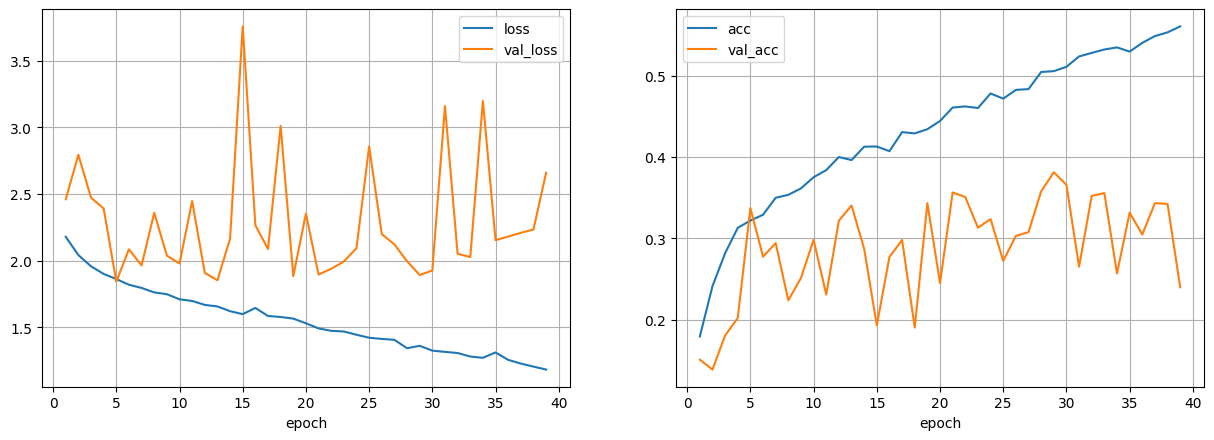

In [ ]:
fig = plt.figure(dpi=100, figsize=(15,5))
ax = plt.subplot(121)
pd.DataFrame(hist).plot(x='epoch', y=['loss', 'val_loss'], grid=True, ax=ax)
ax = plt.subplot(122)
pd.DataFrame(hist).plot(x='epoch', y=['acc', 'val_acc'], grid=True, ax=ax)
plt.show()

Comparando esta figura com a primeira, podrás observar que se continuamos treinando com mais epochs não vamos obter um bom modelo. Por tanto, não é necessário seguir treinando, já que encontramos o melhor modelo possível dada as circustâncias. `Early Stopping` é uma técnica muito simples e efetiva, pelo que é recomendável usá-la sempre.  


> 💡 Dá uma olhada no `Pytorch`, para aprender a como salvar e carregar modelos [click aqui](https://pytorch.org/tutorials/beginner/saving_loading_models.html).

# Dropout

Outra técnica muito popular para reduzir o `Overfitting` é o uso do `Dropout`. Esta técnica se implementa como uma camada extra a nossa Rede Neural cujo objetivo é, durante o Treinamento, "apagar" de maneira aleatória alguns neurônios de maneira que forçamos a nosso modelo a aprender diferentes caminhos dentro da arquitetura para representar os mesmos Dados. 

![](https://www.researchgate.net/profile/Yifan-Zhang-16/publication/332450026/figure/fig5/AS:748477176885249@1555462273508/Neural-network-with-dropout.png)

In [ ]:
# Podemos ver a camada extra: "Dropout" 

def build_model(D_in=32*32*3, H=100, D_out=10, p=0):
    return torch.nn.Sequential(
        torch.nn.Linear(D_in, H),
        torch.nn.ReLU(),
        torch.nn.Dropout(p),
        torch.nn.Linear(H, H),
        torch.nn.ReLU(),
        torch.nn.Dropout(p),
        torch.nn.Linear(H, D_out)
    ).cuda()

Podemos adicionar uma camada de Dropout com a classe `torch.nn.Dropout`. O parâmetro `p` controla a probabilidade de "apagar" uma neurona. Este valor coincide com a proporção (em promédio) de neuronas que serão anuladas numa camada determinada. 


> ⚡ Quando não estamos treinando, geralmente não queremosque a capa Dropout esté ativa de maneira 